## Setup
NOTE: this notebook is more advanced than the ViT one because it uses tensorflow data objects which are smarter and easier to work with. This took some time, so I can also do this for ViT later.

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt
import datetime

## Prepare the data

In [49]:
# loading all images
images = []
labels = []
root = './dataset/merged/'
for folder in os.listdir(root):
    for image in os.listdir(os.path.join(root, folder)):
        images.append(cv2.imread(os.path.join(root, folder, image)))
        labels.append(folder)

In [50]:
y_normal = pd.DataFrame(labels)
y_normal[0].unique()
y = pd.get_dummies(y_normal)
y.head()

,0_Bengin cases,0_Malignant cases,0_Normal cases
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


the dataset creation cell threw a warning aboout ragged sequences here, so i'm gonna detour here

In [51]:
# verify sizes of all images.
resolution = set()
count = 0
for image in images:
    if image.shape != (512, 512, 3):
        resolution.add(image.shape)
        count += 1
print(str(resolution) + '\n' + f"Number of irregular images: {count}")

{(512, 801, 3), (512, 623, 3), (404, 511, 3), (331, 506, 3)}
Number of irregular images: 61


#FIXTHIS 61 images have irregular resolutions. Removing them for now

In [52]:
filtimg = list()

for idx in range(len(images)):
    if images[idx].shape == (512, 512, 3):
        filtimg.append(images[idx])
    else:
        y.drop(idx, axis='rows', inplace=True)

if (len(images) - len(filtimg)) == 61:
    images = filtimg

In [53]:
dataset = np.array(images)

dataset.shape[0] == y.shape[0]

True

In [54]:
y.shape

(1036, 3)

In [55]:
num_classes = np.unique(y).shape[0]
input_shape = (512, 512, 3)

x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size = 0.25,
                                                    shuffle=True)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (777, 512, 512, 3) - y_train shape: (777, 3)
x_test shape: (259, 512, 512, 3) - y_test shape: (259, 3)


# Hyperparameter initialisation and Dataset finalization

In [56]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
img_height = 512
img_width = 512
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Using tensorflow dataset objects moving forward

In [57]:
# importing the training split
train_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1097 files belonging to 3 classes.
Using 878 files for training.


In [58]:
# importing the validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1097 files belonging to 3 classes.
Using 219 files for validation.


In [59]:
# testing for class names presence
class_names = train_ds.class_names
print(class_names)

['Bengin cases', 'Malignant cases', 'Normal cases']


In [60]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 512, 3)
(32,)


In [61]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


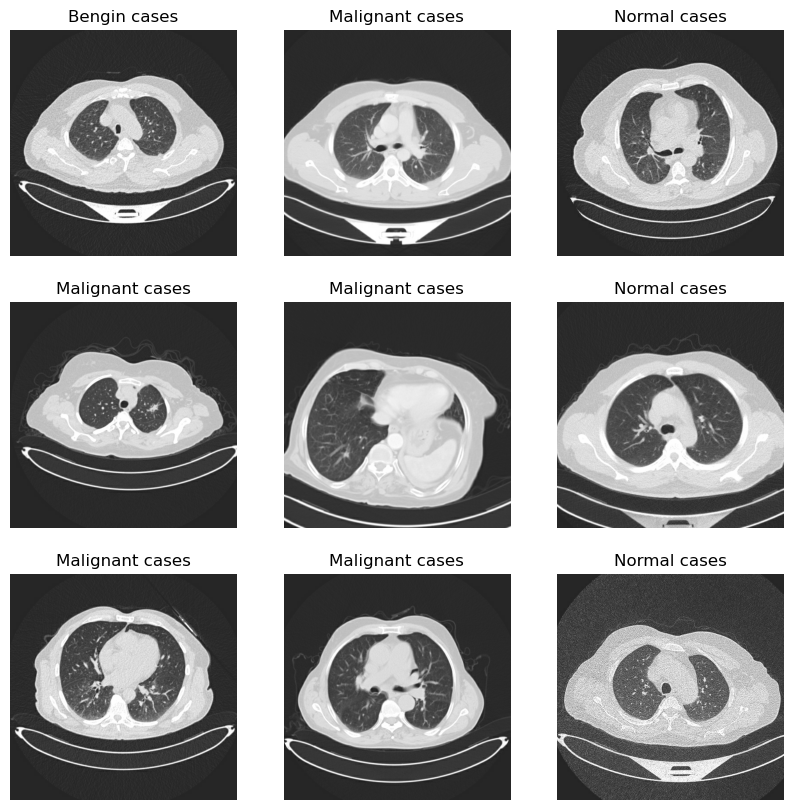

In [62]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [63]:
%reload_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [64]:
# train_ds = configure_for_performance(train_ds)
# val_ds = configure_for_performance(val_ds)

In [65]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  callbacks=[tensorboard_callback]
)

Epoch 1/15


2023-08-03 13:17:54.920349: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


28/28 [==============================] - ETA: 0s - loss: 1.6764 - accuracy: 0.5979

2023-08-03 13:18:02.199981: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3778805760 exceeds 10% of free system memory.


28/28 [==============================] - 16s 396ms/step - loss: 1.6764 - accuracy: 0.5979 - val_loss: 0.4691 - val_accuracy: 0.8402
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9510

2023-08-03 13:18:11.753413: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3778805760 exceeds 10% of free system memory.


28/28 [==============================] - 7s 220ms/step - loss: 0.1745 - accuracy: 0.9510 - val_loss: 0.1482 - val_accuracy: 0.9361
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9841

2023-08-03 13:18:18.397535: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3778805760 exceeds 10% of free system memory.


28/28 [==============================] - 7s 216ms/step - loss: 0.0624 - accuracy: 0.9841 - val_loss: 0.0976 - val_accuracy: 0.9680
Epoch 4/15
24/28 [========================>.....] - ETA: 0s - loss: 0.0168 - accuracy: 0.9948

In [ ]:
model.evaluate(val_ds)

7/7 [==============================] - 0s 10ms/step - loss: 0.0956 - accuracy: 0.9817


[0.09558214992284775, 0.9817351698875427]